In [1]:
from __future__ import print_function

import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
np.random.seed(1)
tf.random.set_seed(2)

NGRAMS = 2
FEATURE_LEN = 128
EPOCHS = 15

# Shalla
df = pd.read_csv('../train-test/data/shalla_2017.csv.bz2')
df

,domain,shalla_cat
0,nicoleaniston.org,porn
1,gadiz.hotfire.net,porn
2,turismorural.com,recreation/travel
3,esfollandodondesea.blogspot.de,porn
4,oliebollen.com,shopping
...,...,...
1571537,divequest.co.uk,recreation/travel
1571538,wetholeshere.com,porn
1571539,teenbody.com,porn
1571540,sex-free-pic.net,porn


In [2]:
df['cat_count'] = df.shalla_cat.apply(lambda c: len(c.split('|')))
sdf = df[df.cat_count == 1]
sdf

,domain,shalla_cat,cat_count
0,nicoleaniston.org,porn,1
1,gadiz.hotfire.net,porn,1
2,turismorural.com,recreation/travel,1
3,esfollandodondesea.blogspot.de,porn,1
4,oliebollen.com,shopping,1
...,...,...,...
1571537,divequest.co.uk,recreation/travel,1
1571538,wetholeshere.com,porn,1
1571539,teenbody.com,porn,1
1571540,sex-free-pic.net,porn,1


In [3]:
dom_group = sdf.groupby('shalla_cat').agg({'domain': 'count'})
dom_group

,domain
shalla_cat,
adv,12712
aggressive,483
alcohol,638
anonvpn,6981
automobile/bikes,893
...,...
weapons,442
webmail,3525
webphone,49


### Take out categories that have less than 1000 domains.

In [4]:
filter_cat = list(dom_group[dom_group.domain > 1000].index)

### Take out categories that have recall less than 0.3

In [5]:
cmat = """
                   adv       0.77      0.42      0.54      2542
               anonvpn       0.77      0.72      0.75      1396
       automobile/cars       0.48      0.19      0.27       627
                  chat       0.59      0.10      0.17      2686
                dating       0.63      0.11      0.19       519
             downloads       0.58      0.41      0.48       835
                 drugs       0.60      0.24      0.34      2227
               dynamic       0.66      0.51      0.58       213
     education/schools       0.86      0.79      0.82      2014
       finance/banking       0.69      0.56      0.62       998
     finance/insurance       0.90      0.83      0.87       616
  finance/moneylending       0.82      0.80      0.81       760
    finance/realestate       0.61      0.38      0.47       276
        fortunetelling       0.79      0.39      0.52       215
                 forum       0.79      0.75      0.77      1612
                gamble       0.79      0.74      0.76      2765
      hobby/games-misc       0.80      0.04      0.08       378
    hobby/games-online       0.67      0.48      0.56      2772
            hobby/pets       0.65      0.36      0.46      3233
             hospitals       0.87      0.67      0.76       327
             jobsearch       0.84      0.46      0.59       859
                models       0.00      0.00      0.00       345
                movies       0.64      0.54      0.58      1112
                 music       0.83      0.81      0.82      1784
                  news       0.52      0.24      0.33      7668
                others       0.50      0.10      0.16      3011
              politics       0.79      0.22      0.35       258
                  porn       0.86      0.92      0.89    165489
               radiotv       0.58      0.50      0.54       712
recreation/restaurants       0.70      0.26      0.38       282
     recreation/sports       0.62      0.64      0.63     24085
     recreation/travel       0.69      0.66      0.68     27789
            redirector       0.81      0.67      0.73      5873
              religion       0.89      0.81      0.84      1838
     science/astronomy       0.69      0.77      0.73       207
         searchengines       0.57      0.23      0.32       220
          sex/lingerie       0.50      0.35      0.41       211
              shopping       0.50      0.67      0.57     33452
               spyware       0.51      0.22      0.31      3666
               tracker       0.58      0.16      0.25       220
                 warez       0.47      0.16      0.23       374
               webmail       0.80      0.55      0.65       705
              webradio       0.54      0.37      0.44       451
"""

import re

excat = []
for l in cmat.split('\n'):
    a = re.split('\s+', l)
    if len(a) > 1:
        cat = a[1]
        recall = float(a[3])
        if recall < 0.3:
            excat.append(cat)
excat

['automobile/cars',
 'chat',
 'dating',
 'drugs',
 'hobby/games-misc',
 'models',
 'news',
 'others',
 'politics',
 'searchengines',
 'spyware',
 'tracker',
 'warez']

In [6]:
filter_cat = [x for x in filter_cat if x not in excat]
filter_cat

['adv',
 'anonvpn',
 'downloads',
 'dynamic',
 'education/schools',
 'finance/banking',
 'finance/insurance',
 'finance/moneylending',
 'finance/realestate',
 'fortunetelling',
 'forum',
 'gamble',
 'hobby/games-online',
 'hobby/pets',
 'hospitals',
 'jobsearch',
 'movies',
 'music',
 'porn',
 'radiotv',
 'recreation/restaurants',
 'recreation/sports',
 'recreation/travel',
 'redirector',
 'religion',
 'science/astronomy',
 'sex/lingerie',
 'shopping',
 'webmail',
 'webradio']

In [7]:
sdf.loc[sdf.shalla_cat.isin(filter_cat) == False, 'shalla_cat'] = 'others'
sdf

/opt/venv37/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,domain,shalla_cat,cat_count
0,nicoleaniston.org,porn,1
1,gadiz.hotfire.net,porn,1
2,turismorural.com,recreation/travel,1
3,esfollandodondesea.blogspot.de,porn,1
4,oliebollen.com,shopping,1
...,...,...,...
1571537,divequest.co.uk,recreation/travel,1
1571538,wetholeshere.com,porn,1
1571539,teenbody.com,porn,1
1571540,sex-free-pic.net,porn,1


In [8]:
sdf.groupby('shalla_cat').agg({'domain': 'count'})

,domain
shalla_cat,
adv,12712
anonvpn,6981
downloads,4177
dynamic,1066
education/schools,10068
finance/banking,4989
finance/insurance,3081
finance/moneylending,3802
finance/realestate,1379


## Preprocessing the input data

In [9]:
# build n-gram list
#vect = CountVectorizer(analyzer='char', max_df=0.3, min_df=3, ngram_range=(NGRAMS, NGRAMS), lowercase=False) 
vect = CountVectorizer(analyzer='char', ngram_range=(NGRAMS, NGRAMS), lowercase=False) 
a = vect.fit_transform(sdf.domain)
vocab = vect.vocabulary_

# sort n-gram by freq (highest -> lowest)
words = []
for b in vocab:
    c = vocab[b]
    #print(b, c, a[:, c].sum())
    words.append((a[:, c].sum(), b))
    #break
words = sorted(words, reverse=True)
words_list = [w[1] for w in words]
num_words = len(words_list)
print("num_words = %d" % num_words)


def find_ngrams(text, n):
    a = zip(*[text[i:] for i in range(n)])
    wi = []
    for i in a:
        w = ''.join(i)
        try:
            idx = words_list.index(w)
        except:
            idx = 0
        wi.append(idx)
    return wi

# build X from index of n-gram sequence
X = np.array(sdf.domain.apply(lambda c: find_ngrams(c, NGRAMS)))

# check max/avg feature
X_len = []
for x in X:
    X_len.append(len(x))

max_feature_len = max(X_len)
avg_feature_len = int(np.mean(X_len))

num_words = 1936


In [10]:
print("Max feature len = %d, Avg. feature len = %d" % (max_feature_len, avg_feature_len))
class_labels = sdf.shalla_cat.astype('category').cat.categories
y = np.array(sdf.shalla_cat.astype('category').cat.codes)

# Split train and test dataset
X_train_valid,  X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
X_train,  X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=21, stratify=y_train_valid)
#X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# backup
y_train_lab = y_train
y_test_lab = y_test

Max feature len = 119, Avg. feature len = 15


In [11]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 2542,
 1: 1396,
 2: 835,
 3: 213,
 4: 2014,
 5: 998,
 6: 616,
 7: 760,
 8: 276,
 9: 215,
 10: 1612,
 11: 2765,
 12: 2772,
 13: 3233,
 14: 327,
 15: 859,
 16: 1112,
 17: 1784,
 18: 22198,
 19: 165489,
 20: 712,
 21: 282,
 22: 24085,
 23: 27789,
 24: 5873,
 25: 1838,
 26: 207,
 27: 211,
 28: 33453,
 29: 705,
 30: 451}

In [12]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 8136,
 1: 4468,
 2: 2674,
 3: 682,
 4: 6443,
 5: 3193,
 6: 1972,
 7: 2434,
 8: 882,
 9: 690,
 10: 5157,
 11: 8850,
 12: 8871,
 13: 10345,
 14: 1048,
 15: 2748,
 16: 3557,
 17: 5707,
 18: 71034,
 19: 529564,
 20: 2278,
 21: 901,
 22: 77073,
 23: 88923,
 24: 18794,
 25: 5881,
 26: 662,
 27: 676,
 28: 107047,
 29: 2256,
 30: 1442}

## Train a LSTM model

In [13]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import load_model

max_features = num_words # 20000
feature_len = FEATURE_LEN # avg_feature_len # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print(len(X_train_valid), 'train+valid sequences')
print(len(X_train), 'train sequences')
print(len(X_valid), 'valid sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train_valid = sequence.pad_sequences(X_train_valid, maxlen=feature_len)
X_train = sequence.pad_sequences(X_train, maxlen=feature_len)
X_valid = sequence.pad_sequences(X_valid, maxlen=feature_len)
X_test = sequence.pad_sequences(X_test, maxlen=feature_len)
print('X_train_valid shape:', X_train_valid.shape)
print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)
print('X_test shape:', X_test.shape)

n_classes = np.max(y_train_valid) + 1
print(n_classes, 'classes')

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train_valid = keras.utils.to_categorical(y_train_valid, n_classes)
y_train = keras.utils.to_categorical(y_train, n_classes)
y_valid = keras.utils.to_categorical(y_valid, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)
print('y_train_valid shape:', y_train_valid.shape)
print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

Using TensorFlow backend.


1230486 train+valid sequences
984388 train sequences
246098 valid sequences
307622 test sequences
Pad sequences (samples x time)
X_train_valid shape: (1230486, 128)
X_train shape: (984388, 128)
X_valid shape: (246098, 128)
X_test shape: (307622, 128)
31 classes
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train_valid shape: (1230486, 31)
y_train shape: (984388, 31)
y_valid shape: (246098, 31)
y_test shape: (307622, 31)


In [14]:
def create_model():
    print('Build model...')

    model = Sequential()
    model.add(Embedding(num_words, 32, input_length=feature_len))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(n_classes, activation='softmax'))

    # try using different optimizers and different optimizer configs
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    #print(model.summary())
    
    return model

In [15]:
import matplotlib.pyplot as plt

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score, log_loss)
from sklearn.linear_model import LogisticRegression

In [16]:
# Train uncalibrated random forest classifier on whole train and validation
# data and evaluate on test data

clf = KerasClassifier(build_fn=create_model, epochs=EPOCHS, batch_size=batch_size, verbose=1)
clf.fit(X_train_valid, y_train_valid)
clf_probs = clf.predict_proba(X_test)
score = log_loss(y_test, clf_probs)

Build model...


/opt/venv37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/15
1230486/1230486 [==============================] - 5751s 5ms/step - loss: 1.0534 - accuracy: 0.6720
Epoch 2/15
1230486/1230486 [==============================] - 5632s 5ms/step - loss: 0.8974 - accuracy: 0.7152
Epoch 3/15
1230486/1230486 [==============================] - 5710s 5ms/step - loss: 0.8630 - accuracy: 0.7258
Epoch 4/15
1230486/1230486 [==============================] - 5746s 5ms/step - loss: 0.8450 - accuracy: 0.7313
Epoch 5/15
1230486/1230486 [==============================] - 5648s 5ms/step - loss: 0.8338 - accuracy: 0.7350
Epoch 6/15
1230486/1230486 [==============================] - 5950s 5ms/step - loss: 0.8259 - accuracy: 0.7371
Epoch 7/15
1230486/1230486 [==============================] - 5887s 5ms/step - loss: 0.8197 - accuracy: 0.7392
Epoch 8/15
1230486/1230486 [==============================] - 5885s 5ms/step - loss: 0.8142 - accuracy: 0.7409
Epoch 9/15
1230486/1230486 [==============================] - 5908s 5ms/step - loss: 0.8093 - accuracy: 0.7424
E

In [17]:
# Train random forest classifier, calibrate on validation data and evaluate
# on test data
clf = KerasClassifier(build_fn=create_model, epochs=EPOCHS, batch_size=batch_size, verbose=1)
clf.fit(X_train, y_train)
clf_probs = clf.predict_proba(X_test)

Build model...


/opt/venv37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/15
984388/984388 [==============================] - 4954s 5ms/step - loss: 1.0807 - accuracy: 0.6646
Epoch 2/15
984388/984388 [==============================] - 4889s 5ms/step - loss: 0.9130 - accuracy: 0.7106
Epoch 3/15
984388/984388 [==============================] - 4882s 5ms/step - loss: 0.8722 - accuracy: 0.7229
Epoch 4/15
984388/984388 [==============================] - 4878s 5ms/step - loss: 0.8518 - accuracy: 0.7293
Epoch 5/15
984388/984388 [==============================] - 5506s 6ms/step - loss: 0.8399 - accuracy: 0.7332
Epoch 6/15
984388/984388 [==============================] - 5544s 6ms/step - loss: 0.8331 - accuracy: 0.7346
Epoch 7/15
984388/984388 [==============================] - 5552s 6ms/step - loss: 0.8241 - accuracy: 0.7374
Epoch 8/15
984388/984388 [==============================] - 5066s 5ms/step - loss: 0.8172 - accuracy: 0.7398
Epoch 9/15
984388/984388 [==============================] - 4967s 5ms/step - loss: 0.8127 - accuracy: 0.7407
Epoch 10/15
984388/

In [18]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((984388, 128), (984388, 31), (246098, 128), (246098, 31))

In [19]:
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(X_valid, np.argmax(y_valid, axis=1))
sig_clf_probs = sig_clf.predict_proba(X_test)
sig_score = log_loss(y_test, sig_clf_probs)

307622/307622 [==============================] - 437s 1ms/step


In [20]:
score, sig_score

(0.7399195194924828, 0.8425819493448737)

### Calibrated LSTM Score

In [21]:
sig_clf_pred = sig_clf.predict(X_test)

307622/307622 [==============================] - 440s 1ms/step


In [22]:
print("\tPrecision: %1.3f" % precision_score(np.argmax(y_test, axis=1), sig_clf_pred, average='macro'))
print("\tRecall: %1.3f" % recall_score(np.argmax(y_test, axis=1), sig_clf_pred, average='macro'))
print("\tF1: %1.3f\n" % f1_score(np.argmax(y_test, axis=1), sig_clf_pred, average='macro'))

fraction_of_positives, mean_predicted_value = \
    calibration_curve(y_test[:, 0], sig_clf_probs[:, 0], n_bins=10)

	Precision: 0.760
	Recall: 0.563
	F1: 0.634



### LSTM Score

In [23]:
clf_pred = clf.predict(X_test)

307622/307622 [==============================] - 472s 2ms/step


In [24]:
print("\tPrecision: %1.3f" % precision_score(np.argmax(y_test, axis=1), clf_pred, average='macro'))
print("\tRecall: %1.3f" % recall_score(np.argmax(y_test, axis=1), clf_pred, average='macro'))
print("\tF1: %1.3f\n" % f1_score(np.argmax(y_test, axis=1), clf_pred, average='macro'))

fraction_of_positives, mean_predicted_value = \
    calibration_curve(y_test[:, 0], clf_probs[:, 0], n_bins=10)

	Precision: 0.732
	Recall: 0.582
	F1: 0.635



## Confusion Matrix

In [25]:
y_pred = clf.predict(X_test)

307622/307622 [==============================] - 450s 1ms/step


In [26]:
p = clf.predict_proba(X_test, verbose=2) # to predict probability
target_names = list(sdf.shalla_cat.astype('category').cat.categories)
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

                        precision    recall  f1-score   support

                   adv       0.76      0.43      0.55      2542
               anonvpn       0.80      0.70      0.74      1396
             downloads       0.55      0.42      0.48       835
               dynamic       0.76      0.55      0.64       213
     education/schools       0.89      0.78      0.83      2014
       finance/banking       0.70      0.57      0.63       998
     finance/insurance       0.96      0.81      0.88       616
  finance/moneylending       0.93      0.79      0.85       760
    finance/realestate       0.64      0.41      0.50       276
        fortunetelling       0.75      0.35      0.48       215
                 forum       0.74      0.79      0.76      1612
                gamble       0.83      0.75      0.79      2765
    hobby/games-online       0.70      0.45      0.55      2772
            hobby/pets       0.64      0.36      0.46      3233
             hospitals       0.81      

In [27]:
sig_y_pred = sig_clf.predict(X_test)

307622/307622 [==============================] - 415s 1ms/step


In [28]:
target_names = list(sdf.shalla_cat.astype('category').cat.categories)
print(classification_report(np.argmax(y_test, axis=1), sig_y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_test, axis=1), sig_y_pred))

                        precision    recall  f1-score   support

                   adv       0.80      0.42      0.55      2542
               anonvpn       0.84      0.67      0.75      1396
             downloads       0.64      0.38      0.47       835
               dynamic       0.83      0.48      0.61       213
     education/schools       0.92      0.76      0.84      2014
       finance/banking       0.80      0.52      0.63       998
     finance/insurance       0.97      0.81      0.88       616
  finance/moneylending       0.95      0.78      0.86       760
    finance/realestate       0.67      0.39      0.49       276
        fortunetelling       0.78      0.34      0.47       215
                 forum       0.79      0.75      0.77      1612
                gamble       0.86      0.73      0.79      2765
    hobby/games-online       0.72      0.44      0.54      2772
            hobby/pets       0.67      0.34      0.45      3233
             hospitals       0.86      

In [29]:
def brier_multi(targets, probs):
    return np.mean(np.sum((probs - targets)**2, axis=1))

In [30]:
brier_multi(y_test, clf_probs)

0.31697795

In [31]:
brier_multi(y_test, sig_clf_probs)

0.3319920792673198

## Save model

## Plotting ROC Curve

In [55]:
y_score = clf_probs

/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


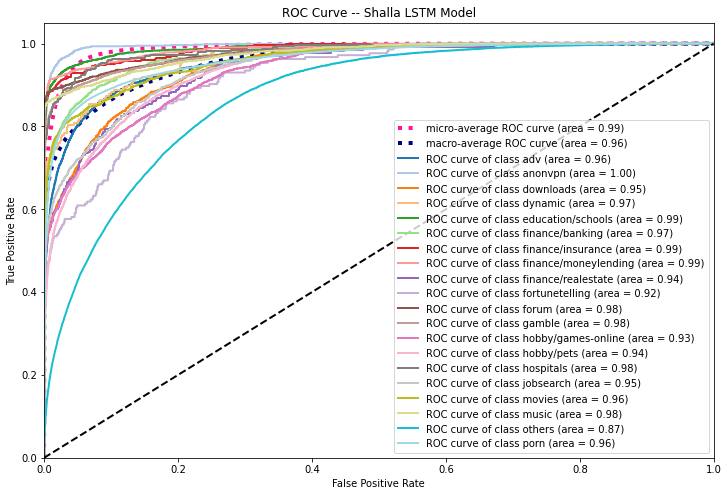

In [56]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(1, figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

cmap = plt.get_cmap("tab20")
colors = cycle([cmap(i) for i in range(n_classes)])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))
    if i >= 19:
        break

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve -- Shalla LSTM Model')
plt.legend(loc="lower right")
plt.show()

In [57]:
fig.savefig('./roc-shalla-lstm.eps', format='eps', dpi=300, bbox_inches="tight", orientation='landscape');

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [58]:
y_score = sig_clf_probs

/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


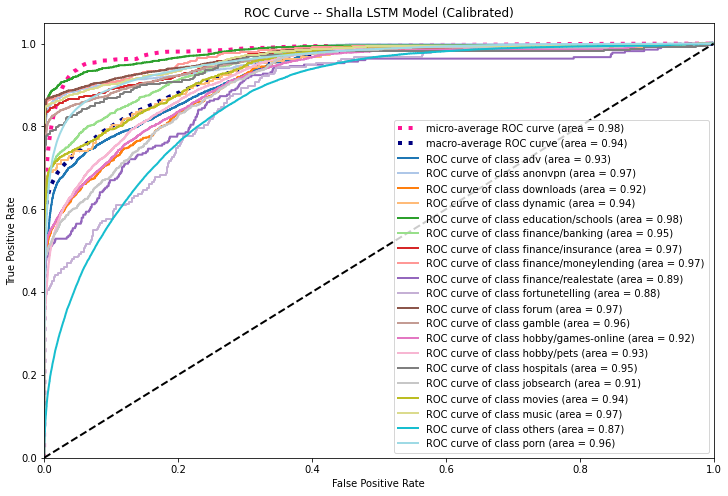

In [59]:
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(1, figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

cmap = plt.get_cmap("tab20")
colors = cycle([cmap(i) for i in range(n_classes)])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))
    if i >= 19:
        break

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve -- Shalla LSTM Model (Calibrated)')
plt.legend(loc="lower right")
plt.show()

In [62]:
fig.savefig('./roc-shalla-lstm-calibrated.eps', format='eps', dpi=300, bbox_inches="tight", orientation='landscape');

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
